# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [4]:
df =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

In [5]:
list(df.head())

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed(mph)',
 'windspeed(ms)',
 'cnt']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


**Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной cnt.**

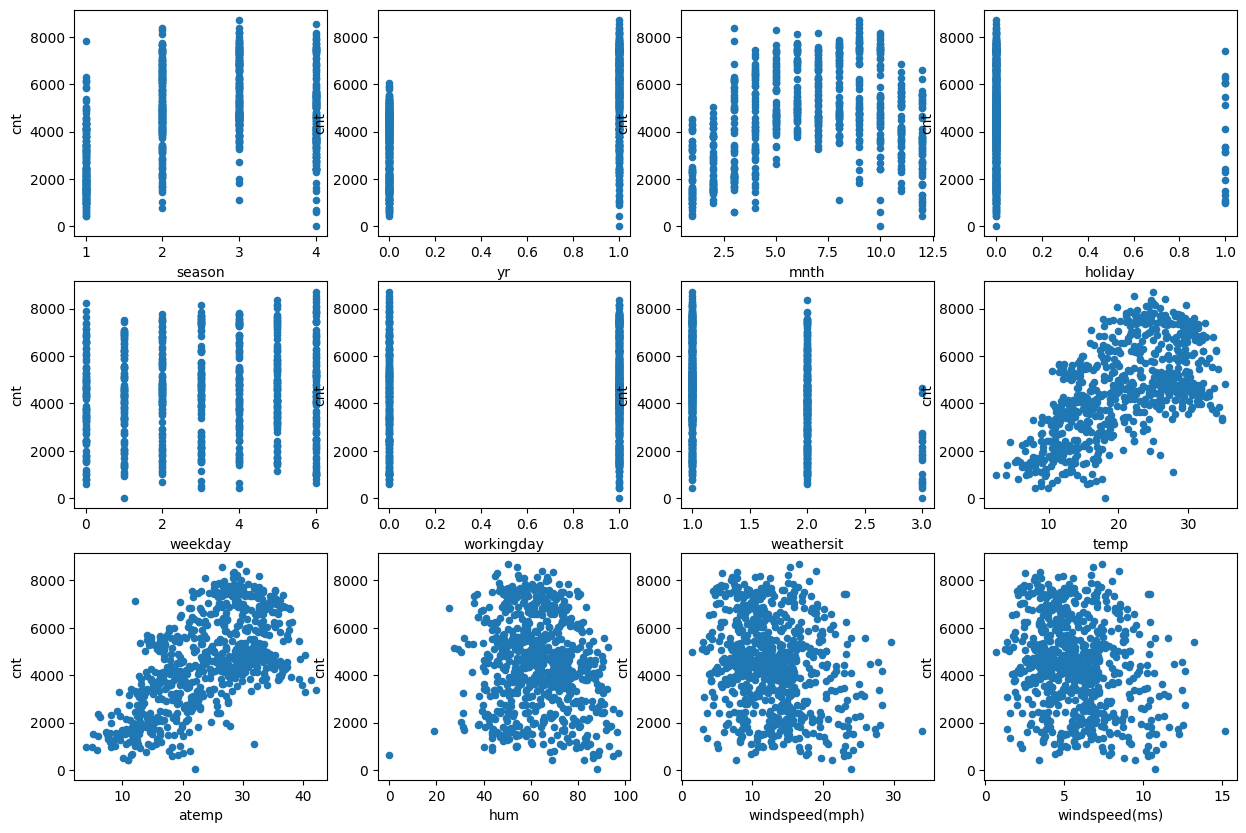

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?

ОТВЕТ:
Синусоидальная зависимость. В летние месяцы заказов больше

2. Укажите один или два признака, от которых число прокатов скорее всего линейно

ОТВЕТ:

temp: температура в Цельсиях

atemp: температура по ощущениям в Цельсиях


## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [13]:
df_corr=df.iloc[:, :-1].corrwith(df.cnt).round(2)
df_corr

season            0.41
yr                0.57
mnth              0.28
holiday          -0.07
weekday           0.07
workingday        0.06
weathersit       -0.30
temp              0.63
atemp             0.63
hum              -0.10
windspeed(mph)   -0.23
windspeed(ms)    -0.23
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [14]:
# Кореляція між 'cnt' та всіма іншими стовпцями
correlation_results=df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()
correlation_results

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [15]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [16]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [17]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [18]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [19]:
df_shuffled

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509153,23.45270,73.3750,11.666643,5.215308,6606
33,1,0,2,0,4,1,1,7.665237,8.89390,43.7826,18.609384,8.318902,1550
300,4,0,10,0,5,1,2,13.564153,15.94060,58.5833,15.375093,6.873086,3747
456,2,1,4,0,0,0,2,17.459153,20.86435,67.6250,11.541889,5.159539,6041
633,4,1,9,0,2,1,1,22.550000,27.20895,57.0000,15.833507,7.078009,7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0,3,0,0,0,1,15.758268,19.00455,52.7391,18.130468,8.104814,2417
106,2,0,4,0,0,0,1,18.723347,22.28480,47.9583,20.334232,9.089956,3744
270,4,0,9,0,3,1,2,26.035000,28.75790,84.8750,9.958143,4.451561,3907
435,1,1,3,0,0,0,1,14.831299,17.98350,47.6957,14.913329,6.666665,4911


In [20]:
model=LinearRegression()
model

LinearRegression()

In [21]:
model.fit(X,y)

LinearRegression()

In [22]:
model.intercept_

4504.354528214392

In [23]:
model.coef_

array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
        1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
        5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13])

In [24]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)',
       'cnt'],
      dtype='object')

In [25]:
for item in zip(df.columns[:-1], model.coef_.round(4)):
  print (f'ваговий коеф. {item[0]}: {item[1]}')
print('Зсув',model.intercept_)

ваговий коеф. season: 570.8638
ваговий коеф. yr: 1021.9654
ваговий коеф. mnth: -141.3017
ваговий коеф. holiday: -86.7593
ваговий коеф. weekday: 137.2251
ваговий коеф. workingday: 56.3919
ваговий коеф. weathersit: -330.2265
ваговий коеф. temp: 367.4837
ваговий коеф. atemp: 585.5494
ваговий коеф. hum: -145.6143
ваговий коеф. windspeed(mph): 12457138390688.885
ваговий коеф. windspeed(ms): -12457138390887.346
Зсув 4504.354528214392


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [26]:
from sklearn.linear_model import Lasso, Ridge

In [27]:
model1=Lasso()
model1

Lasso()

In [28]:
model1.fit(X,y)

Lasso()

In [29]:
for item in zip(df.columns[:-1], model1.coef_.round(9)):
  print (f'ваговий коеф. {item[0]}: {item[1]}')
print('Зсув',model1.intercept_)

ваговий коеф. season: 560.241616031
ваговий коеф. yr: 1019.463494066
ваговий коеф. mnth: -128.730627037
ваговий коеф. holiday: -86.152781334
ваговий коеф. weekday: 137.347893905
ваговий коеф. workingday: 55.212370641
ваговий коеф. weathersit: -332.369856962
ваговий коеф. temp: 376.36323621
ваговий коеф. atemp: 576.530793505
ваговий коеф. hum: -144.129155003
ваговий коеф. windspeed(mph): -197.139689402
ваговий коеф. windspeed(ms): -2.8e-08
Зсув 4504.3488372093025


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [30]:
model2=Ridge()
model2

Ridge()

In [31]:
model2.fit(X,y)

Ridge()

In [32]:
for item in zip(df.columns[:-1], model2.coef_.round(9)):
  print (f'ваговий коеф. {item[0]}: {item[1]}')
print('Зсув',model2.intercept_.round(9))

ваговий коеф. season: 563.064572252
ваговий коеф. yr: 1018.948378788
ваговий коеф. mnth: -131.873320282
ваговий коеф. holiday: -86.746097997
ваговий коеф. weekday: 138.005111179
ваговий коеф. workingday: 55.903110375
ваговий коеф. weathersit: -332.349788499
ваговий коеф. temp: 386.457889192
ваговий коеф. atemp: 566.34704706
ваговий коеф. hum: -145.071327299
ваговий коеф. windspeed(mph): -99.259441082
ваговий коеф. windspeed(ms): -99.259441154
Зсув 4504.348837209


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [33]:
alphas = np.arange(1, 500, 50)

coefs_ls = np.zeros((alphas.shape[0], X.shape[1]))
coefs_rg = np.zeros((alphas.shape[0], X.shape[1]))
for i, alpha in enumerate(alphas):
  model_ls = Lasso(alpha=alphas[i])
  model_ls.fit(X, y)
  coefs_ls[i] = model_ls.coef_

for i, alpha in enumerate(alphas):
  model_rg = Ridge(alpha=alphas[i])
  model_rg.fit(X, y)
  coefs_rg[i] = model_rg.coef_


Проанализируйте динамику весов при увеличении параметра регуляризации:

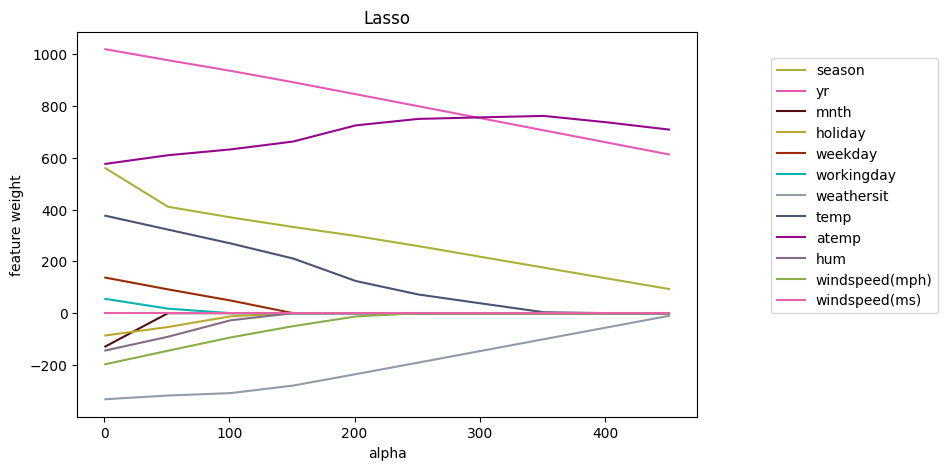

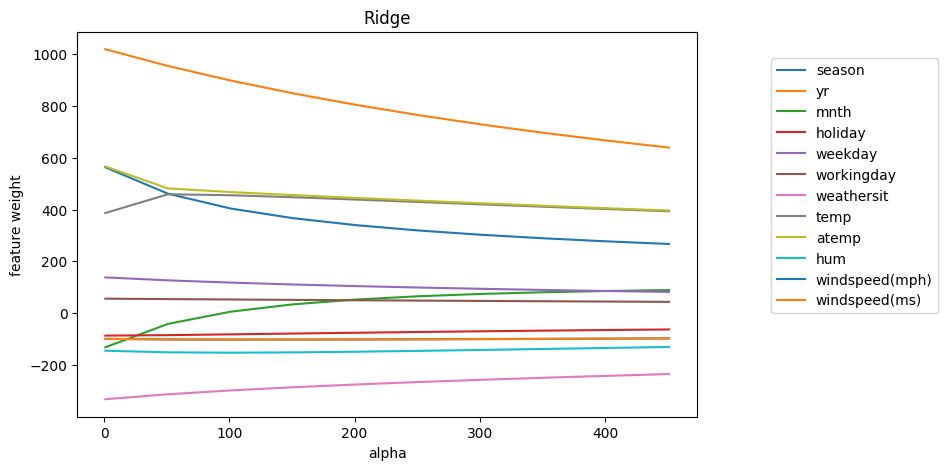

In [34]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_ls.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_rg.T, df.columns):
    plt.plot(alphas, coef, label=feature)

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?

ОТВЕТ: регуляризатор Lasso агрессивнее уменьшает веса

2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.

ОТВЕТ: Якщо зробити alpha дуже великим в методі Lasso, то це призведе до того, що багато ваг моделі будуть зведені до нуля. графік представлений нижче
велике alpha приводить до того, що в регуляризаційному члені, збільшується штраф за великі значення ваг.
якщо alpha дуже великий, модель буде намагатися зменшити ваги кожного ознаки до мінімуму, і багато ваг може стати нульовими.

3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.

ОТВЕТ:
Так, Lasso (L1 регуляризація) може використовуватися для розрідженості моделі, і при великих значеннях параметра alpha може статися так, що один чи більше коефіцієнтів, які відповідають незначущим ознакам, стануть точно нульовими. windspeed є менш важливим призначеним, тому його вага стає нульовою при великому значенні alpha в Lasso.
Ridge (L2 регуляризація) зазвичай не призводить до точно нульових ваг. Тому Ridge може зменшити ваги, але не призведе до повного виключення жодного призначеного.
для критерію меньше $10^{-3}$, Lasso частіше виключатиме признаки, оскільки він призводить до точно нульових ваг. Ridge, найімовірніше, зменшить ваги, але не до такого рівня.

4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

ОТВЕТ:
Lasso (L1 регуляризація) частіше використовується для відбору неінформативних признаків через властивість розрідженості. Оскільки Lasso штрафує ваги моделі відповідно до суми модулів (абсолютних значень), великі значення ваг зменшуються, а деякі можуть стати нульовими.

In [35]:
alphas1 = np.arange(1, 2000, 50)

coefs_ls1 = np.zeros((alphas1.shape[0], X.shape[1]))
coefs_rg1 = np.zeros((alphas1.shape[0], X.shape[1]))
for i, alpha in enumerate(alphas1):
  model_ls1 = Lasso(alpha=alphas1[i])
  model_ls1.fit(X, y)
  coefs_ls1[i] = model_ls1.coef_


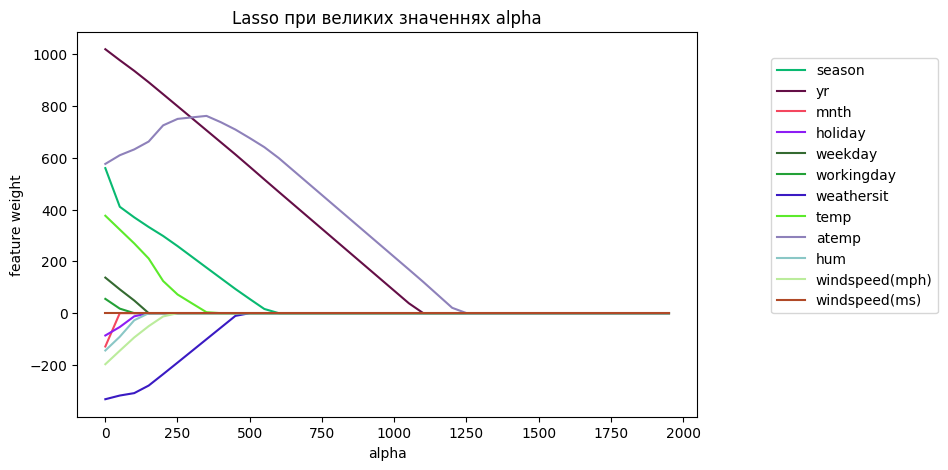

In [36]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_ls1.T, df.columns):
    plt.plot(alphas1, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso при великих значеннях alpha")

plt.show()

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [11]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (6, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y, marker='o', linestyle='-', color='b')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()


Alpha = 6


season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08




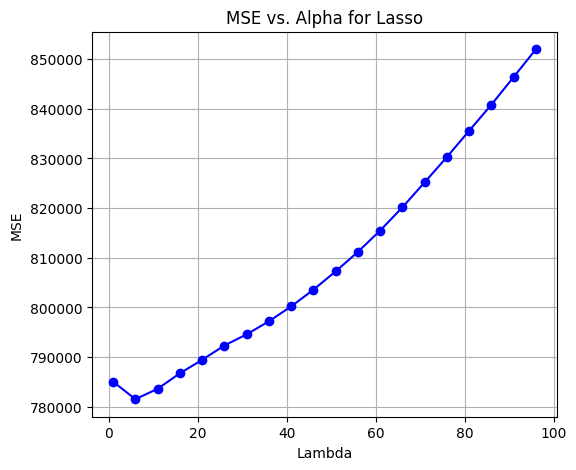

In [45]:
from sklearn.linear_model import LassoCV

alphas_cv = np.arange(1, 100, 5)
model_cv = LassoCV(alphas=alphas_cv, cv=3)
model_cv.fit(X, y)

title = "MSE vs. Alpha for Lasso"
data = list(zip(model_cv.alphas_, np.mean(model_cv.mse_path_, axis=1)))
print('\nAlpha = ' + str(model_cv.alpha_))
print('\n')
for item in zip(df_shuffled.columns[:-1], model_cv.coef_):
  print (f'{item[0]}: {item[1]}')
print('\n')
create_plot(data, title, xlabel='Lambda', ylabel='MSE')


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


In [55]:
model_cv.mse_path_.shape

(20, 3)

Minimum MSE: 733725.7604052249
Alpha: 6
Minimum MSE: 799433.1673691692
Alpha: 1
Minimum MSE: 796979.8955193626
Alpha: 51


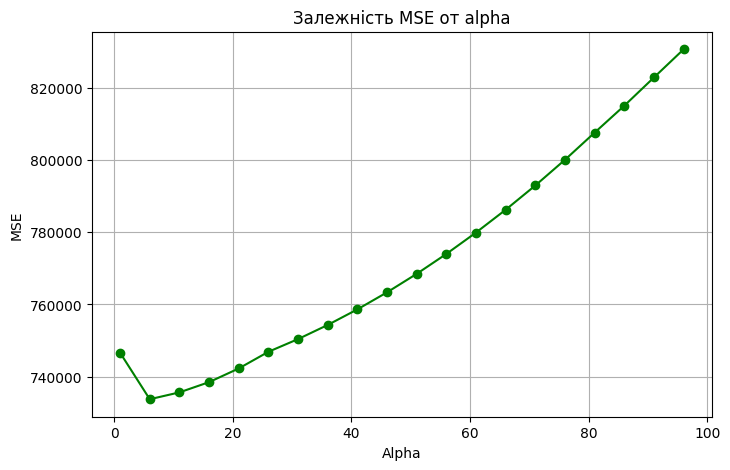

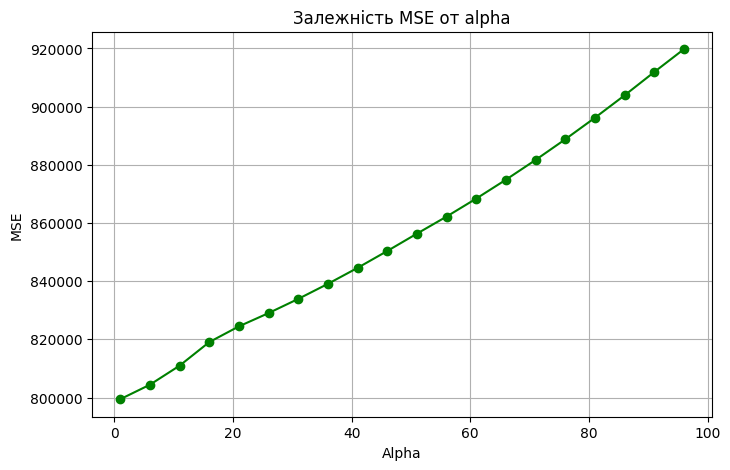

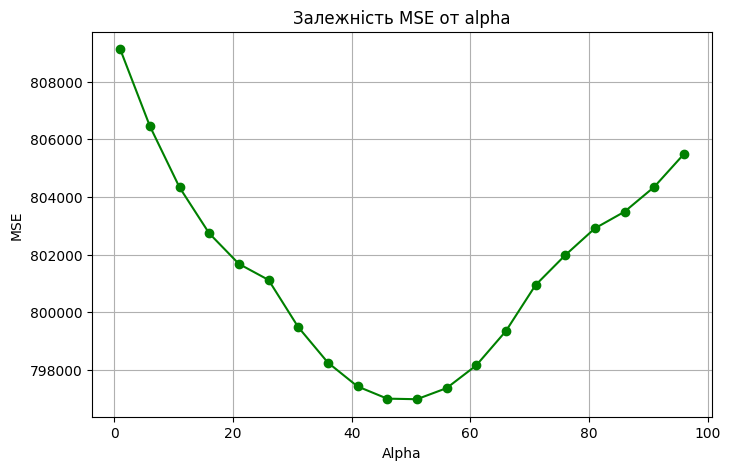

In [61]:
def alpha_index(model_cv, index):
    plt.figure(figsize=(8, 5))
    indexes = np.argsort(model_cv.alphas_)
    mse_mean = model_cv.mse_path_[:, index]
    x=alphas
    y=mse_mean[indexes]
    plt.plot(x, y, marker='o', linestyle='-', color='g')
    plt.grid(1)
    plt.title('Залежність MSE от alpha')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')

    print('Minimum MSE: %s\nAlpha: %s' % (np.min(mse_mean), alphas[indexes[np.argmin(mse_mean)]]))

for i in range(3):
  alpha_index(model_cv, i)

In [63]:
model_lasso = Lasso(alpha=6)
model_lasso.fit(X, y)
for weight, name in sorted(zip(model_lasso.coef_, df.columns[:-1])):
    print('%s - %s' % (name, weight))

weathersit - -330.5598567399817
windspeed(mph) - -191.77140847135036
hum - -140.00740550068844
mnth - -100.03952614356629
holiday - -83.29395987529904
windspeed(ms) - -2.6854702314758792e-08
workingday - 51.557085614073735
weekday - 132.50446549095795
temp - 370.67985503003405
season - 532.0189828413535
atemp - 581.396931065498
yr - 1015.0602226430595


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
# ???

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
# ???

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [ ]:
# ???

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.